# Path configuration

In [ ]:
tracking_uri = "http://localhost:5000"
experiment_name = "MLflow Experiment tracking"
import os

BASE_DIR = os.path.dirname(os.getcwd())

raw_data_path = os.path.join(BASE_DIR, "raw_data", "ValeursFoncieres-2024.txt")
saved_csv_data_path = os.path.join(BASE_DIR, "csv_data")
reference_data_path = os.path.join(BASE_DIR, "reference_data")
models_path = os.path.join(BASE_DIR, "models")

print(f"Models path: {models_path}")
print(f"Raw data path: {raw_data_path}")
print(f"Saved CSV data path: {saved_csv_data_path}")

Models path: c:\Users\Utilisateur\ai_app_prototype_demo\models
Raw data path: c:\Users\Utilisateur\ai_app_prototype_demo\raw_data\ValeursFoncieres-2024.txt
Data path: c:\Users\Utilisateur\ai_app_prototype_demo\csv_data


# Phase 0 : Filtrage des données DVF


## MLflow

In [188]:
import mlflow

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/Utilisateur/ai_app_prototype_demo/mlruns/1', creation_time=1765534570047, experiment_id='1', last_update_time=1765534570047, lifecycle_stage='active', name='MLflow Experiment tracking', tags={}>

In [189]:
import numpy as np
import pandas as pd
import os

# Chargement
if not os.path.exists(raw_data_path):
    print(f"Le fichier {raw_data_path} est introuvable. Veuillez le télécharger depuis https://www.data.gouv.fr/fr/datasets/donnees-des-valeurs-foncieres/ et le placer dans le dossier 'raw_data'.")
df = pd.read_csv(raw_data_path, sep='|', low_memory=False)

# Harmonisation
df['Commune'] = df['Commune'].str.upper()

# Filtrage LILLE
df_lille = df[
    (df['Commune'] == 'LILLE') &
    (df['Nature mutation'] == 'Vente') &
    (df['Surface reelle bati'].notna()) &
    (df['Valeur fonciere'].notna())
].copy()

# Filtrage BORDEAUX
df_bordeaux = df[
    (df['Commune'] == 'BORDEAUX') &
    (df['Nature mutation'] == 'Vente') &
    (df['Surface reelle bati'].notna()) &
    (df['Valeur fonciere'].notna())
].copy()

# Conversion en float
for df_city in [df_lille, df_bordeaux]:
    df_city['Valeur fonciere'] = df_city['Valeur fonciere'].astype(str).str.replace(',', '.').str.replace(' ', '').astype(float)
    df_city['Surface reelle bati'] = df_city['Surface reelle bati'].astype(str).str.replace(',', '.').str.replace(' ', '').astype(float)

# Calcul du prix au m²
df_lille['prix_m2'] = df_lille['Valeur fonciere'] / df_lille['Surface reelle bati']
df_bordeaux['prix_m2'] = df_bordeaux['Valeur fonciere'] / df_bordeaux['Surface reelle bati']

# Export
os.makedirs(saved_csv_data_path, exist_ok=True)
df_lille.to_csv(f"{saved_csv_data_path}/lille_2024.csv", index=False)
df_bordeaux.to_csv(f"{saved_csv_data_path}/bordeaux_2024.csv", index=False)

print("Export terminé.")

Export terminé.


# Phase 1 — Modélisation du prix au m² à Lille (2022) pour les logements de 4 pièces

In [190]:
df_lille = pd.read_csv(f"{saved_csv_data_path}/lille_2024.csv")

In [191]:
df_lille.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7367 entries, 0 to 7366
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Identifiant de document     0 non-null      float64
 1   Reference document          0 non-null      float64
 2   1 Articles CGI              0 non-null      float64
 3   2 Articles CGI              0 non-null      float64
 4   3 Articles CGI              0 non-null      float64
 5   4 Articles CGI              0 non-null      float64
 6   5 Articles CGI              0 non-null      float64
 7   No disposition              7367 non-null   int64  
 8   Date mutation               7367 non-null   object 
 9   Nature mutation             7367 non-null   object 
 10  Valeur fonciere             7367 non-null   float64
 11  No voie                     7356 non-null   float64
 12  B/T/Q                       508 non-null    object 
 13  Type de voie                7315 

In [192]:
df_lille.columns

Index(['Identifiant de document', 'Reference document', '1 Articles CGI',
       '2 Articles CGI', '3 Articles CGI', '4 Articles CGI', '5 Articles CGI',
       'No disposition', 'Date mutation', 'Nature mutation', 'Valeur fonciere',
       'No voie', 'B/T/Q', 'Type de voie', 'Code voie', 'Voie', 'Code postal',
       'Commune', 'Code departement', 'Code commune', 'Prefixe de section',
       'Section', 'No plan', 'No Volume', '1er lot',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
       'Nombre de lots', 'Code type local', 'Type local', 'Identifiant local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain', 'prix_m2'],
      dtype='object')

In [193]:
df_lille.describe()

c:\Users\Utilisateur\ai_app_prototype_demo\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Utilisateur\ai_app_prototype_demo\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Valeur fonciere,No voie,...,4eme lot,5eme lot,Nombre de lots,Code type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture speciale,Surface terrain,prix_m2
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7367.000000,7.367000e+03,7356.000000,...,54.000000,10.00000,7367.000000,7367.000000,0.0,7367.000000,7367.000000,0.0,2353.000000,7.367000e+03
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.004887,3.863410e+05,205.510740,...,30.981481,43.10000,0.945975,2.430976,NaN,43.268087,1.370979,NaN,229.801955,inf
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069738,1.170403e+06,1110.144609,...,38.667665,43.28831,0.942589,0.797826,NaN,155.947716,1.693574,NaN,519.787383,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000e+00,1.000000,...,3.000000,6.00000,0.000000,1.000000,NaN,0.000000,0.000000,NaN,4.000000,5.238345e-04
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.350000e+05,12.000000,...,5.250000,9.00000,0.000000,2.000000,NaN,0.000000,0.000000,NaN,73.000000,3.552590e+03
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2.030000e+05,32.000000,...,9.000000,20.00000,1.000000,2.000000,NaN,24.000000,1.000000,NaN,115.000000,1.175000e+04
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,3.300000e+05,85.000000,...,36.000000,69.00000,1.000000,3.000000,NaN,59.000000,2.000000,NaN,199.000000,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.229000e+07,9892.000000,...,127.000000,124.00000,34.000000,4.000000,NaN,6566.000000,11.000000,NaN,9165.000000,inf


In [194]:
df_lille.describe(exclude= np.number)

,Date mutation,Nature mutation,B/T/Q,Type de voie,Code voie,Voie,Commune,Section,Surface Carrez du 1er lot,Surface Carrez du 2eme lot,Surface Carrez du 3eme lot,Surface Carrez du 4eme lot,Surface Carrez du 5eme lot,Type local,Nature culture
count,7367,7367,508,7315,7367,7367,7367,7367,1960,459,55,14,2,7367,2353
unique,261,1,10,24,952,938,1,191,1274,227,24,7,2,4,4
top,19/12/2024,Vente,B,RUE,1769,COLBERT,LILLE,C,"17,70","92,00","64,51","18,30","18,10",Appartement,S
freq,76,7367,359,5964,113,113,7367,400,12,7,3,4,1,2972,2344


In [195]:
df_lille['Nombre pieces principales'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7367 entries, 0 to 7366
Series name: Nombre pieces principales
Non-Null Count  Dtype  
--------------  -----  
7367 non-null   float64
dtypes: float64(1)
memory usage: 57.7 KB


In [196]:
df_lille['Nombre pieces principales'].astype('int')

0       0
1       5
2       1
3       0
4       5
       ..
7362    0
7363    3
7364    0
7365    0
7366    0
Name: Nombre pieces principales, Length: 7367, dtype: int64

## Appart & maison de 4 pieces

In [197]:
df_lille_filtered = df_lille[df_lille['Nombre pieces principales'] == 4]

In [198]:
df_lille_filtered['Type local'].unique()

array(['Maison', 'Appartement'], dtype=object)

### Maison

In [199]:
df_maison = df_lille_filtered[df_lille_filtered['Type local'] == 'Maison']

### Appart

In [200]:
df_appart = df_lille_filtered[df_lille_filtered['Type local'] == 'Appartement']

## 4. Features 

In [201]:
required_columns = ['Surface reelle bati', 'Nombre pieces principales',
'Type local','Surface terrain','Nombre de lots','prix_m2']

### Maison

In [202]:
df_maison_ = df_maison[required_columns]

In [203]:
df_maison_.shape

(267, 6)

In [204]:
df_maison_.describe(exclude=np.number)

,Type local
count,267
unique,1
top,Maison
freq,267


In [205]:
df_maison_.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,prix_m2
count,267.000000,267.0,263.000000,267.000000,267.000000
mean,83.857678,4.0,162.167300,0.011236,5452.631606
std,23.287238,0.0,160.738475,0.105601,10533.444152
min,49.000000,4.0,21.000000,0.000000,694.444444
25%,68.000000,4.0,84.000000,0.000000,2420.526316
50%,80.000000,4.0,124.000000,0.000000,3002.564103
75%,93.000000,4.0,178.000000,0.000000,3658.791477
max,230.000000,4.0,1650.000000,1.000000,57260.691667


### Appart

In [206]:
df_appart_ = df_appart[required_columns]

In [207]:
df_appart_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 269 entries, 7 to 7289
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Surface reelle bati        269 non-null    float64
 1   Nombre pieces principales  269 non-null    float64
 2   Type local                 269 non-null    object 
 3   Surface terrain            22 non-null     float64
 4   Nombre de lots             269 non-null    int64  
 5   prix_m2                    269 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 14.7+ KB


## 6. **Nettoyer les données** :
    - Supprimer les lignes avec valeurs manquantes sur les colonnes utilisées
    - Identifier et retirer les valeurs aberrantes (prix au m² trop faible ou trop élevé)

### Maison

In [208]:
df_maison_.isna().any(axis=0)

Surface reelle bati          False
Nombre pieces principales    False
Type local                   False
Surface terrain               True
Nombre de lots               False
prix_m2                      False
dtype: bool

In [209]:
df_maison_.dropna(axis=0, inplace=True)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_27576\2148659308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_maison_.dropna(axis=0, inplace=True)


In [210]:
df_maison_.shape

(263, 6)

### Appart

In [211]:
df_appart_.isna().any(axis=0)

Surface reelle bati          False
Nombre pieces principales    False
Type local                   False
Surface terrain               True
Nombre de lots               False
prix_m2                      False
dtype: bool

In [212]:
df_appart_.dropna(axis=0,inplace=True)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_27576\1012287777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_appart_.dropna(axis=0,inplace=True)


In [213]:
df_appart_.shape

(22, 6)

## Outliers

In [214]:
def drop_outliers(df:pd.DataFrame, column:str):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR=q3-q1

    without_outliers = df[((df[column]>(q1-1.5*IQR)) & (df[column]<(q3+1.5*IQR)))]
    return without_outliers
    


In [215]:
import matplotlib.pyplot as plt
import seaborn as sns

### Maison

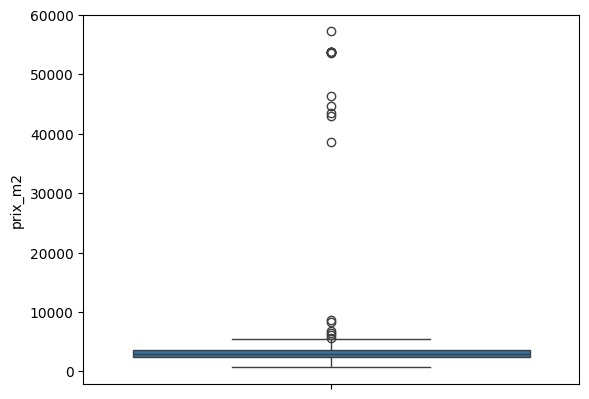

In [216]:
sns.boxplot(df_maison_['prix_m2'])
plt.show()

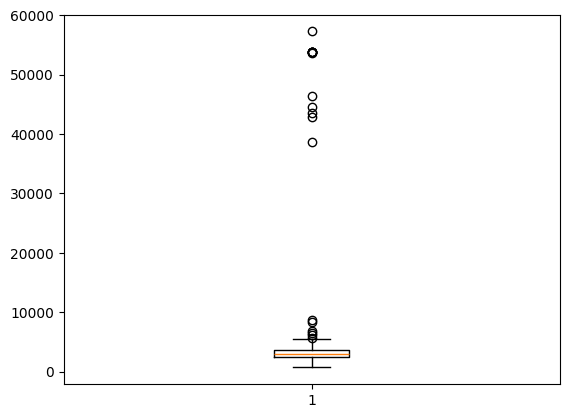

In [217]:
plt.boxplot(df_maison_['prix_m2'])
plt.show()

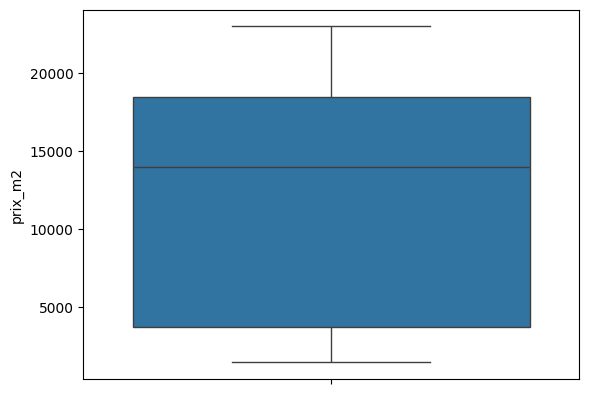

In [218]:
sns.boxplot(df_appart_['prix_m2'])
plt.show()

In [219]:
df_maison_to_process = drop_outliers(df_maison_, 'prix_m2')
df_maison_to_process.head()

,Surface reelle bati,Nombre pieces principales,Type local,Surface terrain,Nombre de lots,prix_m2
5,70.0,4.0,Maison,285.0,0,2000.000000
14,90.0,4.0,Maison,71.0,0,3005.555556
25,68.0,4.0,Maison,194.0,0,2941.176471
58,112.0,4.0,Maison,159.0,0,3943.535714
70,115.0,4.0,Maison,120.0,0,1347.826087


In [220]:
df_appart_to_process = drop_outliers(df_appart_, 'prix_m2')
df_appart_to_process.head()

,Surface reelle bati,Nombre pieces principales,Type local,Surface terrain,Nombre de lots,prix_m2
798,73.0,4.0,Appartement,276.0,0,20821.917808
1569,45.0,4.0,Appartement,58.0,0,1728.444444
2180,100.0,4.0,Appartement,264.0,0,16600.000000
2187,100.0,4.0,Appartement,264.0,0,16600.000000
2191,100.0,4.0,Appartement,264.0,0,16600.000000


### Appart

In [221]:
df_appart_num_fea = df_appart_to_process.drop('Type local', axis=1)

In [222]:
df_appart_num_fea.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,prix_m2
count,22.000000,22.0,22.000000,22.0,22.000000
mean,76.954545,4.0,157.681818,0.0,11888.997698
std,19.662576,0.0,78.296376,0.0,7885.927137
min,45.000000,4.0,57.000000,0.0,1477.611940
25%,65.000000,4.0,90.250000,0.0,3753.826531
50%,74.000000,4.0,127.000000,0.0,13960.377358
75%,93.750000,4.0,249.750000,0.0,18461.538462
max,120.000000,4.0,276.000000,0.0,22972.972973


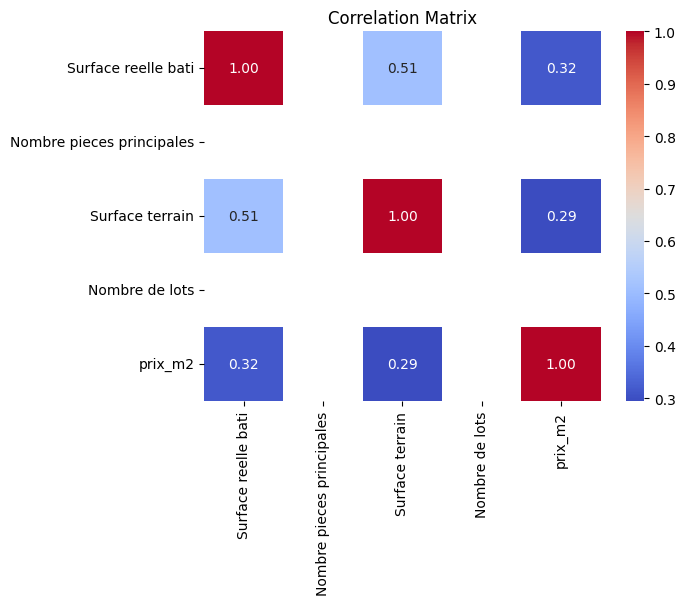

In [223]:
sns.heatmap(df_appart_num_fea.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

array([[<Axes: title={'center': 'Surface reelle bati'}>,
        <Axes: title={'center': 'Nombre pieces principales'}>],
       [<Axes: title={'center': 'Surface terrain'}>,
        <Axes: title={'center': 'Nombre de lots'}>],
       [<Axes: title={'center': 'prix_m2'}>, <Axes: >]], dtype=object)

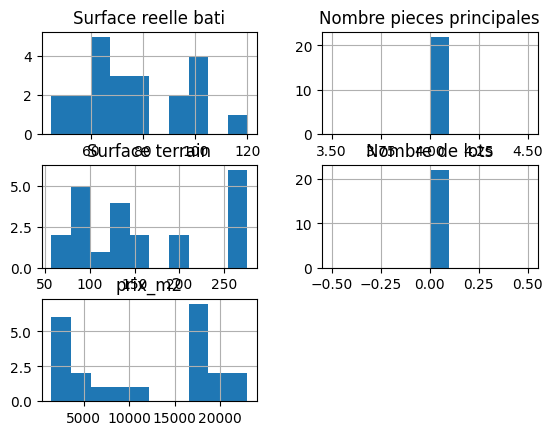

In [224]:
df_appart_num_fea.hist()

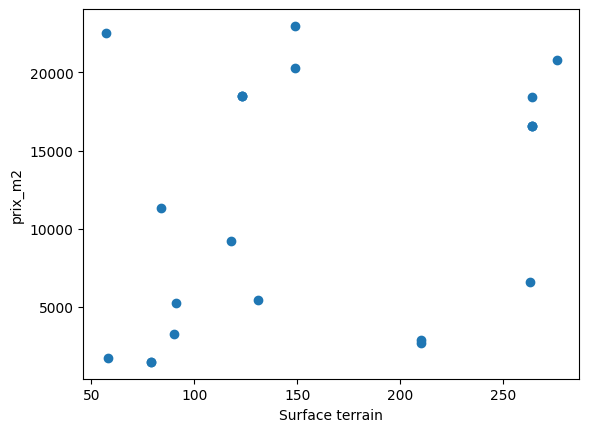

In [225]:
plt.scatter(df_appart_num_fea['Surface terrain'],df_appart_num_fea['prix_m2'])
plt.xlabel('Surface terrain')
plt.ylabel('prix_m2')
plt.show()

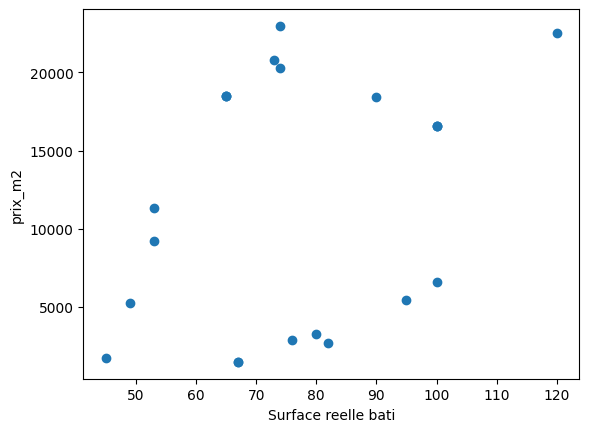

In [226]:
plt.scatter(df_appart_num_fea['Surface reelle bati'],df_appart_num_fea['prix_m2'])
plt.xlabel('Surface reelle bati')
plt.ylabel('prix_m2')
plt.show()

### Maison

In [227]:
df_maison_num_fea = df_maison_to_process.drop('Type local', axis=1)

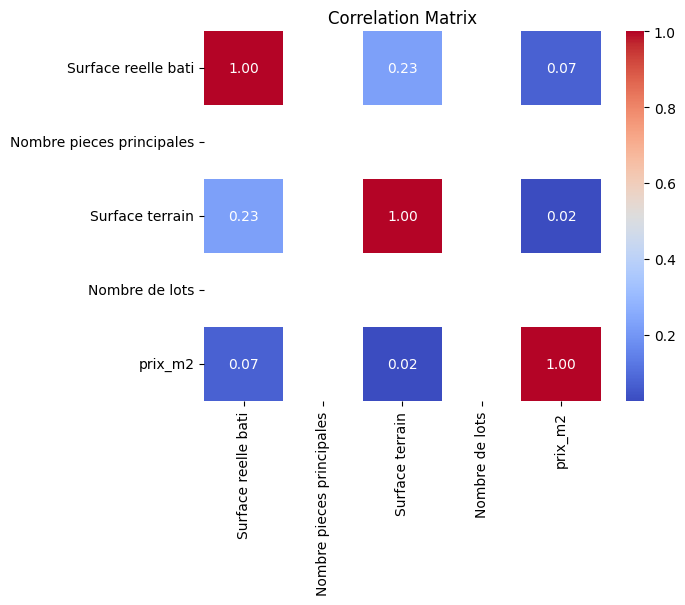

In [228]:
sns.heatmap(df_maison_num_fea.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [229]:
#df_numeric = df_maison_to_process.select_dtypes(include='number')

array([[<Axes: title={'center': 'Surface reelle bati'}>,
        <Axes: title={'center': 'Nombre pieces principales'}>],
       [<Axes: title={'center': 'Surface terrain'}>,
        <Axes: title={'center': 'Nombre de lots'}>],
       [<Axes: title={'center': 'prix_m2'}>, <Axes: >]], dtype=object)

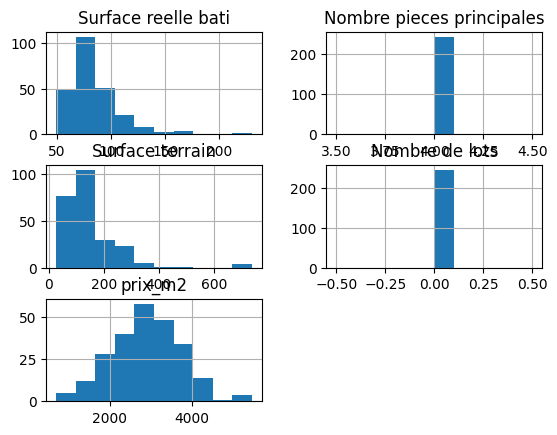

In [230]:
df_maison_num_fea.hist()

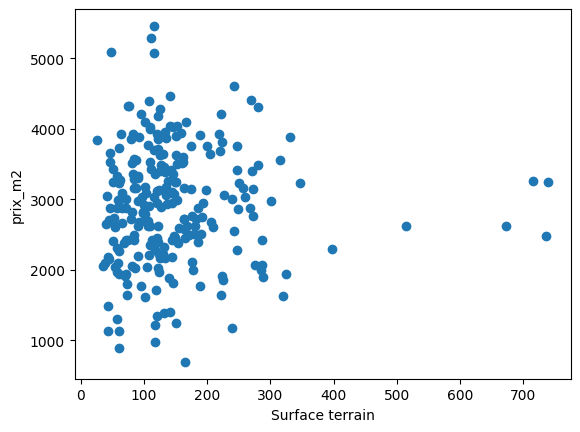

In [231]:
plt.scatter(df_maison_num_fea['Surface terrain'],df_maison_num_fea['prix_m2'])
plt.xlabel('Surface terrain')
plt.ylabel('prix_m2')
plt.show()

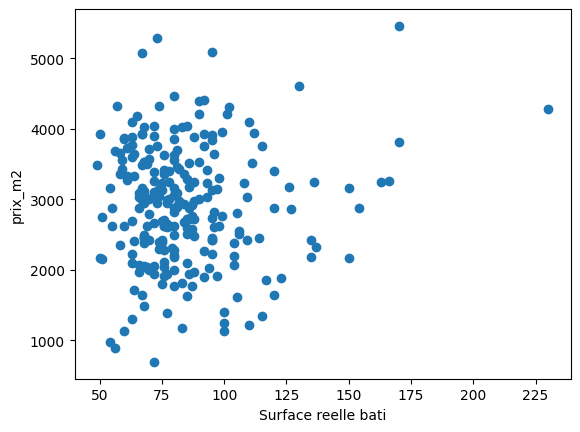

In [232]:
plt.scatter(df_maison_num_fea['Surface reelle bati'],df_maison_num_fea['prix_m2'])
plt.xlabel('Surface reelle bati')
plt.ylabel('prix_m2')
plt.show()

In [233]:
from sklearn.model_selection import train_test_split

In [234]:
from sklearn.preprocessing import StandardScaler

## 7. Drop columns

### Appart

In [235]:
# X, y calculation
X_appart = df_appart_to_process.drop(columns=['Type local','prix_m2'], axis = 1)
y_appart = df_appart_to_process[['prix_m2']]

In [236]:
X_appart.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 798 to 7289
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Surface reelle bati        22 non-null     float64
 1   Nombre pieces principales  22 non-null     float64
 2   Surface terrain            22 non-null     float64
 3   Nombre de lots             22 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 880.0 bytes


In [237]:
X_appart.shape

(22, 4)

# Split train /test data

In [238]:
# Splitting train & test data
Xa_train,  Xa_test, ya_train, ya_test = train_test_split(X_appart,y_appart,test_size = 0.2, random_state=42)

In [239]:
reference_data_a = pd.concat([Xa_train, ya_train], axis=1)
reference_data_a.to_csv(f"{reference_data_path}/reference_data_appart_lille.csv", index=False)

# Standardization

In [240]:
# Standardization
ScalerXa = StandardScaler()
Scalerya = StandardScaler()

In [241]:
# train data
Xa_train_scaled = ScalerXa.fit_transform(Xa_train)
ya_train_scaled = Scalerya.fit_transform(ya_train)

# test data
Xa_test_scaled = ScalerXa.transform(Xa_test)
ya_test_scaled = Scalerya.transform(ya_test)

### Maison

In [242]:
X_maison = df_maison_to_process.drop(columns=['Type local','prix_m2'], axis = 1)
y_maison = df_maison_to_process[['prix_m2']]

In [243]:
X_maison.shape

(244, 4)

In [244]:
X_maison.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 5 to 7351
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Surface reelle bati        244 non-null    float64
 1   Nombre pieces principales  244 non-null    float64
 2   Surface terrain            244 non-null    float64
 3   Nombre de lots             244 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 9.5 KB


In [245]:
Xm_train,  Xm_test, ym_train, ym_test = train_test_split(X_maison,y_maison,test_size = 0.2, random_state=42)

In [246]:
reference_data_m = pd.concat([Xm_train, ym_train], axis=1)
reference_data_m.to_csv(f"{reference_data_path}/reference_data_maison_lille.csv", index=False)

In [247]:
ScalerXm = StandardScaler()
Scalerym = StandardScaler()
# train data
Xm_train_scaled = ScalerXm.fit_transform(Xm_train)
ym_train_scaled = Scalerym.fit_transform(ym_train)

# test data
Xm_test_scaled = ScalerXm.transform(Xm_test)
ym_test_scaled = Scalerym.transform(ym_test)

## 8. scikit-learn models

### Appart

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# -------------------------------------------
# 1. DEFINE MODELS
# -------------------------------------------
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "RandomForestRegressor": RandomForestRegressor()
}

# Store results
pred_a = []
mse_a = []
models_metrics_appart = {}

# -------------------------------------------
# 2. Start the experiment
# -------------------------------------------
mlflow.set_experiment("sklearn_regression_experiment_appart_lille")

for model_name, model in models.items():

    with mlflow.start_run(run_name=model_name):

        # Enable sklearn autologging
        mlflow.sklearn.autolog(log_input_examples=False, log_model_signatures=True)

        # Fit model
        model.fit(Xa_train_scaled, ya_train_scaled)

        # Predict
        pred = model.predict(Xa_test_scaled)
        pred_a.append(pred)

        # Compute MSE
        mse = mean_squared_error(ya_test_scaled, pred)
        mse_a.append(mse)

        # Log custom metric
        mlflow.log_metric("mse", mse)

        # Register model in MLflow
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            registered_model_name=f"{model_name}ModelAppartLille"
        )

        # Save model + metric in your dict
        models_metrics_appart[model_name] = (model, mse)

        print("Run ID:", mlflow.active_run().info.run_id)
        print(f"MSE ({model_name}):", mse)


c:\Users\Utilisateur\ai_app_prototype_demo\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[1.1998453903355555, 0.49677106363096923, 0.5188965056385143]

In [254]:
models_metrics_appart

{'LinearRegression': (LinearRegression(), 1.1998453903355555),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.49677106363096923),
 'RandomForestRegressor': (RandomForestRegressor(), 0.5188965056385143)}

### Maison

In [255]:
models_metrics_maison = {}

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_squared_error

pred_m = []
mse_m = []
models_metrics_maison = {}

# Set experiment name
mlflow.set_experiment("sklearn_regression_experiment_maison_lille")

for model in models:

    model_name = model.__class__.__name__

    with mlflow.start_run(run_name=model_name):

        # Enable sklearn autologging
        mlflow.sklearn.autolog(log_input_examples=False, log_model_signatures=True)

        # Train the model
        model.fit(Xm_train_scaled, ym_train_scaled)

        # Predict
        pred = model.predict(Xm_test_scaled)
        pred_m.append(pred)

        # Compute MSE
        mse = mean_squared_error(ym_test_scaled, pred)
        mse_m.append(mse)

        # Log the custom MSE metric
        mlflow.log_metric("mse", mse)

        # Register the model in MLflow
        mlflow.sklearn.log_model(
            sk_model=model,
            name="model",
            registered_model_name=f"{model_name}ModelMaisonLille"
        )

        # Store model + metric in dictionary
        models_metrics_maison[model_name] = (model, mse)

        print("Run ID:", mlflow.active_run().info.run_id)
        print(f"MSE ({model_name}):", mse)


c:\Users\Utilisateur\ai_app_prototype_demo\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[1.3965182444217863, 2.857103876348896, 1.5607430432692542]

In [257]:
models_metrics_maison


{'LinearRegression': (LinearRegression(), 1.3965182444217863),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 2.857103876348896),
 'RandomForestRegressor': (RandomForestRegressor(), 1.5607430432692542)}

## 9. GridSearchCV

In [258]:
from sklearn.model_selection import GridSearchCV

### Appart

In [259]:
# Optimiser Decision Tree avec GridSearchCV
dt_params = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_dt.fit(Xa_train_scaled, ya_train_scaled)
best_dt = grid_dt.best_estimator_

##"Decision Tree Optimisé", 
mse = eval_model(ya_test_scaled, best_dt.predict(Xa_test_scaled))


name_model = best_dt.__class__.__name__
name_model += "Optimized"
models_metrics_appart[name_model] = (best_dt,mse)


# Optimiser Random Forest avec GridSearchCV
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(Xa_train_scaled, ya_train_scaled)
best_rf = grid_rf.best_estimator_

##"Random Forest Optimisé",

mse = eval_model(ya_test_scaled, best_rf.predict(Xa_test_scaled))

name_model = best_rf.__class__.__name__
name_model += "Optimized"
models_metrics_appart[name_model] = (best_rf,mse)


c:\Users\Utilisateur\ai_app_prototype_demo\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [260]:
models_metrics_appart

{'LinearRegression': (LinearRegression(), 1.1998453903355555),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.49677106363096923),
 'RandomForestRegressor': (RandomForestRegressor(), 0.5188965056385143),
 'DecisionTreeRegressorOptimized': (DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
  1.067810432606421),
 'RandomForestRegressorOptimized': (RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42),
  0.41840607129304325)}

### Maison

In [261]:
# Optimiser Decision Tree avec GridSearchCV
dt_params = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_dt.fit(Xm_train_scaled, ym_train_scaled)
best_dt = grid_dt.best_estimator_

##"Decision Tree Optimisé", 
mse = eval_model(ym_test_scaled, best_dt.predict(Xm_test_scaled))


name_model = best_dt.__class__.__name__
name_model += "Optimized"
models_metrics_maison[name_model] = (best_dt,mse)


# Optimiser Random Forest avec GridSearchCV
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(Xm_train_scaled, ym_train_scaled)
best_rf = grid_rf.best_estimator_

##"Random Forest Optimisé",

mse = eval_model(ym_test_scaled, best_rf.predict(Xm_test_scaled))

name_model = best_rf.__class__.__name__
name_model += "Optimized"
models_metrics_maison[name_model] = (best_rf,mse)


c:\Users\Utilisateur\ai_app_prototype_demo\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [262]:
models_metrics_maison

{'LinearRegression': (LinearRegression(), 1.3965182444217863),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 2.857103876348896),
 'RandomForestRegressor': (RandomForestRegressor(), 1.5607430432692542),
 'DecisionTreeRegressorOptimized': (DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
  1.5920129653983146),
 'RandomForestRegressorOptimized': (RandomForestRegressor(max_depth=10, min_samples_split=5, random_state=42),
  1.5239019296336758)}

## 10. XGBRegressor

In [263]:
!pip install xgboost


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [264]:
import xgboost as xgb

In [265]:
# extract categorical features
#cat_features = X.select_dtypes(exclude = np.number).colimns.tolist()
#for col in cat_features:
#   X[col] = X[col].astype('category')

### Appart

In [266]:
# Create matrices
dm_train_a = xgb.DMatrix(Xa_train_scaled,ya_train_scaled)
dm_test_a = xgb.DMatrix(Xa_test_scaled,ya_test_scaled)

In [267]:
# Define hyperparameters
params = {"objective": "reg:squarederror",
          'eval_metric': 'rmse',
          "tree_method": "hist"}

n = 100
evals = [(dm_test_a, "validation"), (dm_train_a, "train")]

evals_result = {}

model = xgb.train(
   params=params,
   dtrain=dm_train_a,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10,
   # Activate early stopping
   early_stopping_rounds=10,
   evals_result=evals_result  # ← clé pour récupérer les métriques
)



2025/12/12 13:58:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dacf681a665c4740b4a284e8b7e9b953', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:1.07424	train-rmse:0.78832
[10]	validation-rmse:0.60738	train-rmse:0.12466
[20]	validation-rmse:0.50048	train-rmse:0.06591
[30]	validation-rmse:0.48290	train-rmse:0.06314
[40]	validation-rmse:0.47937	train-rmse:0.06303
[50]	validation-rmse:0.47909	train-rmse:0.06303
[59]	validation-rmse:0.47909	train-rmse:0.06303


2025/12/12 13:58:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run bemused-trout-602 at: http://localhost:5000/#/experiments/1/runs/dacf681a665c4740b4a284e8b7e9b953
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [268]:
rmse_list = evals_result["validation"]["rmse"]
best_rmse = rmse_list[model.best_iteration]
best_mse = best_rmse ** 2
print(f"Best RMSE: {best_rmse}")
print(f"Best MSE: {best_mse}")

Best RMSE: 0.47909343009144834
Best MSE: 0.22953051475678948


In [269]:
ypred= model.predict(dm_test_a)
mse=mean_squared_error(ya_test_scaled,ypred)

In [270]:
mse

0.2295296533850646

In [271]:
model_name = model.__class__.__name__
model_name

'Booster'

#### en utilisant l’API scikit-learn de XGBoost

### mlflow: tracking model & autolog metrics

In [ ]:
import mlflow
import mlflow.xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

mlflow.set_experiment("xgboost_regression_experiment")

with mlflow.start_run():

    # Enable autologging
    mlflow.xgboost.autolog(log_input_examples=False, log_model_signatures=True)

    # Define model
    model_regressor = XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        tree_method='hist',
        n_estimators=100,
        early_stopping_rounds=10
    )

    # Train the model
    model_regressor.fit(
        Xa_train_scaled,
        ya_train_scaled,
        eval_set=[(Xa_test_scaled, ya_test_scaled)]
    )

    # Predict
    ypred_regressor = model_regressor.predict(Xa_test_scaled)

    # Compute a custom metric
    mse_regressor = mean_squared_error(ya_test_scaled, ypred_regressor)

    # Log the custom metric
    mlflow.log_metric("mse", mse_regressor)

    # Register the model (fixed argument name)
    mlflow.xgboost.log_model(
        xgb_model=model_regressor,            # <-- use xgb_model=, not model=
        name="model",
        registered_model_name="XGBRegressorModelAppartLille"
    )

    print("Run ID:", mlflow.active_run().info.run_id)
    print("MSE:", mse_regressor)


[0]	validation_0-rmse:1.07424
[1]	validation_0-rmse:0.97013
[2]	validation_0-rmse:0.88746
[3]	validation_0-rmse:0.82692
[4]	validation_0-rmse:0.78052
[5]	validation_0-rmse:0.74631
[6]	validation_0-rmse:0.72100
[7]	validation_0-rmse:0.70220
[8]	validation_0-rmse:0.66422
[9]	validation_0-rmse:0.63303
[10]	validation_0-rmse:0.60738
[11]	validation_0-rmse:0.58624
[12]	validation_0-rmse:0.56872
[13]	validation_0-rmse:0.55410
[14]	validation_0-rmse:0.54188
[15]	validation_0-rmse:0.53165
[16]	validation_0-rmse:0.52308
[17]	validation_0-rmse:0.51589
[18]	validation_0-rmse:0.50985
[19]	validation_0-rmse:0.50476
[20]	validation_0-rmse:0.50048
[21]	validation_0-rmse:0.49686
[22]	validation_0-rmse:0.49416
[23]	validation_0-rmse:0.49166
[24]	validation_0-rmse:0.48975
[25]	validation_0-rmse:0.48814
[26]	validation_0-rmse:0.48678
[27]	validation_0-rmse:0.48551
[28]	validation_0-rmse:0.48456
[29]	validation_0-rmse:0.48358
[30]	validation_0-rmse:0.48290
[31]	validation_0-rmse:0.48219
[32]	validation_0-

2025/12/12 13:58:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/12 13:58:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'XGBRegressorModel' already exists. Creating a new version of this model...
2025/12/12 13:58:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBRegressorModel, version 3


Run ID: ae9ffe43eb124de88d061feb53501449
MSE: 0.22952960111768306
🏃 View run salty-shark-137 at: http://localhost:5000/#/experiments/2/runs/ae9ffe43eb124de88d061feb53501449
🧪 View experiment at: http://localhost:5000/#/experiments/2


Created version '3' of model 'XGBRegressorModel'.


In [273]:
model_name = model_regressor.__class__.__name__
model_name

'XGBRegressor'

In [274]:
models_metrics_appart

{'LinearRegression': (LinearRegression(), 1.1998453903355555),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.49677106363096923),
 'RandomForestRegressor': (RandomForestRegressor(), 0.5188965056385143),
 'DecisionTreeRegressorOptimized': (DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
  1.067810432606421),
 'RandomForestRegressorOptimized': (RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42),
  0.41840607129304325)}

In [275]:
models_metrics_appart[model_name]=(model_regressor,mse_regressor)

In [276]:
models_metrics_appart

{'LinearRegression': (LinearRegression(), 1.1998453903355555),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.49677106363096923),
 'RandomForestRegressor': (RandomForestRegressor(), 0.5188965056385143),
 'DecisionTreeRegressorOptimized': (DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
  1.067810432606421),
 'RandomForestRegressorOptimized': (RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42),
  0.41840607129304325),
 'XGBRegressor': (XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=10,
               enable_categorical=False, eval_metric='rmse', feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_ca

### Maison 

In [277]:
from xgboost import XGBRegressor

model_regressor = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    tree_method='hist',
    n_estimators=100, early_stopping_rounds=10
)


model_regressor.fit(Xm_train_scaled, ym_train_scaled, eval_set=[(Xm_test_scaled,ym_test_scaled)])
ypred_regressor = model_regressor.predict(Xm_test_scaled)
mse_regressor = mean_squared_error(ym_test_scaled,ypred_regressor)
mse_regressor
model_name = model_regressor.__class__.__name__
model_name
models_metrics_maison[model_name]=(model_regressor,mse_regressor)
models_metrics_maison

2025/12/12 13:58:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dea62e934bcf43998c94b9da65009b5b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation_0-rmse:1.15424
[1]	validation_0-rmse:1.16286
[2]	validation_0-rmse:1.14696
[3]	validation_0-rmse:1.15741
[4]	validation_0-rmse:1.17079
[5]	validation_0-rmse:1.14633
[6]	validation_0-rmse:1.14148
[7]	validation_0-rmse:1.12789
[8]	validation_0-rmse:1.14585
[9]	validation_0-rmse:1.15263
[10]	validation_0-rmse:1.16318
[11]	validation_0-rmse:1.18636
[12]	validation_0-rmse:1.19258
[13]	validation_0-rmse:1.19982
[14]	validation_0-rmse:1.19323
[15]	validation_0-rmse:1.19543
[16]	validation_0-rmse:1.20464
[17]	validation_0-rmse:1.21837


2025/12/12 13:58:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run bold-smelt-864 at: http://localhost:5000/#/experiments/2/runs/dea62e934bcf43998c94b9da65009b5b
🧪 View experiment at: http://localhost:5000/#/experiments/2


{'LinearRegression': (LinearRegression(), 1.3965182444217863),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 2.857103876348896),
 'RandomForestRegressor': (RandomForestRegressor(), 1.5607430432692542),
 'DecisionTreeRegressorOptimized': (DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
  1.5920129653983146),
 'RandomForestRegressorOptimized': (RandomForestRegressor(max_depth=10, min_samples_split=5, random_state=42),
  1.5239019296336758),
 'XGBRegressor': (XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=10,
               enable_categorical=False, eval_metric='rmse', feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_

In [278]:
Xa_train_scaled.shape

(17, 4)

In [279]:
Xm_train_scaled.shape

(195, 4)

🏡 Meilleur modèle Appartements : XGBRegressor (MSE = 0.23)
🏠 Meilleur modèle Maisons      : XGBRegressor (MSE = 1.27)


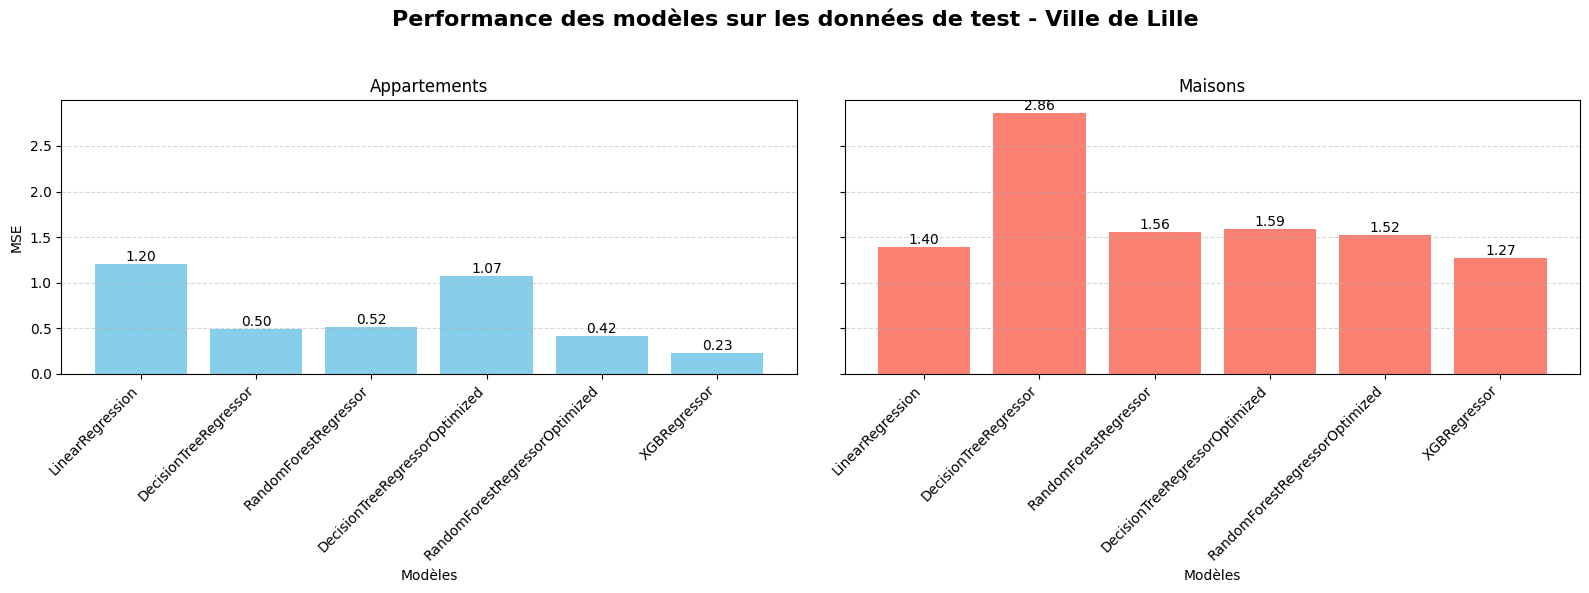

In [280]:
import matplotlib.pyplot as plt
import json

# ========================
# Données pour appartements
# ========================
mse_list_appart = []
mse_dict_appart = {}
min_mse_a = float('inf')
best_model_a = ""

for key in models_metrics_appart.keys():
    mse = models_metrics_appart[key][1]
    mse_list_appart.append(mse)
    mse_dict_appart[key] = mse
    if mse < min_mse_a:
        min_mse_a = mse
        best_model_a = key

labels_appart = list(models_metrics_appart.keys())

# =====================
# Données pour maisons
# =====================
mse_list_maison = []
mse_dict_maison = {}
min_mse_m = float('inf')
best_model_m = ""

for key in models_metrics_maison.keys():
    mse = models_metrics_maison[key][1]
    mse_list_maison.append(mse)
    mse_dict_maison[key] = mse
    if mse < min_mse_m:
        min_mse_m = mse
        best_model_m = key

labels_maison = list(models_metrics_maison.keys())

# =========================
# Sauvegarde dans un fichier
# =========================
mse_results_lille = {
    "appartements": mse_dict_appart,
    "maisons": mse_dict_maison
}

with open("mse_lille.json", "w") as f:
    json.dump(mse_results_lille, f, indent=4)

# =========================
# Affichage du meilleur modèle
# =========================
print(f"🏡 Meilleur modèle Appartements : {best_model_a} (MSE = {min_mse_a:.2f})")
print(f"🏠 Meilleur modèle Maisons      : {best_model_m} (MSE = {min_mse_m:.2f})")

# =========================
# Création des subplots
# =========================
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle("Performance des modèles sur les données de test - Ville de Lille", fontsize=16, fontweight='bold')

# Subplot 1 – Appartements
x_appart = range(len(labels_appart))
bars_appart = axes[0].bar(x_appart, mse_list_appart, color='skyblue')
axes[0].set_title("Appartements")
axes[0].set_ylabel("MSE")
axes[0].set_xlabel("Modèles")
axes[0].set_xticks(x_appart)
axes[0].set_xticklabels(labels_appart, rotation=45, ha='right')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars_appart:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Subplot 2 – Maisons
x_maison = range(len(labels_maison))
bars_maison = axes[1].bar(x_maison, mse_list_maison, color='salmon')
axes[1].set_title("Maisons")
axes[1].set_xlabel("Modèles")
axes[1].set_xticks(x_maison)
axes[1].set_xticklabels(labels_maison, rotation=45, ha='right')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars_maison:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Save models

In [281]:
import joblib

In [ ]:
# Save model and scaler
# Créer le dossier s'il n'existe pas
os.makedirs(f'{models_path}', exist_ok=True)
joblib.dump({'model_a': models_metrics_appart[best_model_a][0], 
             'scaler_Xa': ScalerXa, 
             'scaler_ya':Scalerya,
             'model_m': models_metrics_maison[best_model_m][0], 
             'scaler_Xm': ScalerXm, 
             'scaler_ym':Scalerym}, 
            f'{models_path}/best_model_lille.pkl')

['c:\\Users\\Utilisateur\\ai_app_prototype_demo\\models/best_model_lille.pkl']

In [283]:
dict_model_appart={}
for model_name in models_metrics_appart:
    dict_model_appart[model_name] = models_metrics_appart[model_name][0]
    

In [284]:
dict_model_appart

{'LinearRegression': LinearRegression(),
 'DecisionTreeRegressor': DecisionTreeRegressor(),
 'RandomForestRegressor': RandomForestRegressor(),
 'DecisionTreeRegressorOptimized': DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
 'RandomForestRegressorOptimized': RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
 

In [285]:
joblib.dump(dict_model_appart, f'{models_path}/models_appart_lille.pkl')

['c:\\Users\\Utilisateur\\ai_app_prototype_demo\\models/models_appart_lille.pkl']

In [286]:
dict_model_maison={}
for model_name in models_metrics_maison:
    dict_model_maison[model_name] = models_metrics_maison[model_name][0]

In [287]:
dict_model_maison

{'LinearRegression': LinearRegression(),
 'DecisionTreeRegressor': DecisionTreeRegressor(),
 'RandomForestRegressor': RandomForestRegressor(),
 'DecisionTreeRegressorOptimized': DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42),
 'RandomForestRegressorOptimized': RandomForestRegressor(max_depth=10, min_samples_split=5, random_state=42),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=na

In [288]:
joblib.dump(dict_model_maison, f'{models_path}/models_maison_lille.pkl')

['c:\\Users\\Utilisateur\\ai_app_prototype_demo\\models/models_maison_lille.pkl']